# Model Comparison and Analysis

This notebook compares the performance of all trained models on both L_bracket and Plate_hole datasets.

## Models Compared:
1. **PointNetMLPJoint** - Joint encoder-decoder architecture
2. **DenseNoFFT** - Dense concatenation without Fourier features
3. **SpectralDeepONet** - DeepONet with Fourier features
4. **VanillaDeepONet** - Standard DeepONet without Fourier features

## Datasets:
- **L_bracket** - L-shaped bracket geometry
- **Plate_hole** - Plate with hole geometry

In [9]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import h5py
import pandas as pd
from pn_models import PointNetMLPJoint
from benchmarks import VanillaDeepONet, SpectralDeepONet, DenseNoFFT
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {device}')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

Using device: cuda


In [10]:
# Set up directory paths
current_dir = os.getcwd()
repo_dir = os.path.dirname(current_dir)

# Data paths
L_bracket_data_path = Path(repo_dir, 'L_Bracket', 'L_bracket_stress.h5')
Plate_hole_data_path = Path(repo_dir, 'Plate_Hole', 'Plate_hole_stress.h5')

# Model directories
model_dirs = {
    'PointNetMLPJoint': Path(repo_dir, 'PointNetMLPJoint', 'Trained_models'),
    'DenseNoFFT': Path(repo_dir, 'DenseNoFFT', 'Trained_models'),
    'SpectralDeepONet': Path(repo_dir, 'SpectralDeepONet', 'Trained_models'),
    'VanillaDeepONet': Path(repo_dir, 'VanillaDeepONet', 'Trained_models')
}

# Example geometry paths
L_bracket_example_path = Path(current_dir, 'L_bracket_example.h5')
Plate_hole_example_path = Path(current_dir, 'Plate_hole_example.h5')

print('Data paths configured:')
print(f'  L_bracket data: {L_bracket_data_path.exists()}')
print(f'  Plate_hole data: {Plate_hole_data_path.exists()}')
print(f'  L_bracket example: {L_bracket_example_path.exists()}')
print(f'  Plate_hole example: {Plate_hole_example_path.exists()}')

Data paths configured:
  L_bracket data: True
  Plate_hole data: True
  L_bracket example: True
  Plate_hole example: True


## Helper Functions

In [11]:
def load_h5_data(path):
    """Load all samples from HDF5 file."""
    samples = []
    with h5py.File(path, 'r') as hf:
        keys = sorted(hf.keys(), key=lambda x: int(x.split('_')[1]))
        for key in keys:
            group = hf[key]
            sample = {
                'points': group['points'][:],  # (N, 2)
                'stress': group['stress'][:],  # (N, 1)
            }
            # Stack for tensor conversion
            coord_stress = np.hstack((sample['points'], sample['stress']))  # (N, 3)
            samples.append(torch.from_numpy(coord_stress).float())
    return samples

def get_validation_split(samples, test_size=0.2, random_state=42):
    """Split data into train and validation sets (matching training script)."""
    n_samples = len(samples)
    idxs = list(range(n_samples))
    train_idx, val_idx = train_test_split(idxs, test_size=test_size, random_state=random_state)
    val_samples = [samples[i] for i in val_idx]
    return val_samples, val_idx

print('Data loading functions defined')

Data loading functions defined


In [12]:
# Import the helper function for loading models
from load_models_helper import load_model_with_checkpoint

def load_model_and_checkpoint(model_path, model_type):
    """Wrapper around helper function for loading models."""
    return load_model_with_checkpoint(model_path, model_type, device=device)

print('Model loading function defined')

Model loading function defined


In [13]:
def evaluate_model(model, val_samples, norm_params):
    """Evaluate model on validation samples."""
    model.eval()
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for sample in val_samples:
            sample = sample.to(device)
            points = sample[:, :2]  # (N, 2)
            stress = sample[:, 2:3]  # (N, 1)
            
            # Normalize inputs
            points_norm = (points - norm_params['coord_center']) / norm_params['coord_half_range']
            stress_norm = (stress - norm_params['stress_mean']) / norm_params['stress_std']
            
            # Add batch dimension
            geom_points = points_norm.unsqueeze(0)  # (1, N, 2)
            query_points = points_norm.unsqueeze(0)  # (1, N, 2)
            
            # Predict
            pred_norm = model(geom_points, query_points)  # (1, N, 1)
            
            # Denormalize predictions
            pred = pred_norm * norm_params['stress_std'] + norm_params['stress_mean']
            
            all_preds.append(pred.squeeze().cpu().numpy())
            all_targets.append(stress.squeeze().cpu().numpy())
    
    # Concatenate all predictions and targets
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    # Calculate metrics
    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_preds)
    mae = np.mean(np.abs(all_targets - all_preds))
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

print('Evaluation function defined')

Evaluation function defined


# L_bracket Dataset Comparison

Comparing all models trained on the L_bracket dataset using the same validation set.

In [14]:
# Load L_bracket data
print('Loading L_bracket dataset...')
L_bracket_samples = load_h5_data(L_bracket_data_path)
L_bracket_val_samples, L_bracket_val_idx = get_validation_split(L_bracket_samples)
print(f'Total samples: {len(L_bracket_samples)}')
print(f'Validation samples: {len(L_bracket_val_samples)}')

Loading L_bracket dataset...
Total samples: 5000
Validation samples: 1000


In [15]:
# Evaluate all L_bracket models
print('Evaluating L_bracket models...\n')
L_bracket_results = {}

for model_name in ['PointNetMLPJoint', 'DenseNoFFT', 'SpectralDeepONet', 'VanillaDeepONet']:
    print(f'Evaluating {model_name}...')
    model_path = list(model_dirs[model_name].glob('L-*.pt'))[0]
    
    try:
        model, norm_params, ckpt = load_model_and_checkpoint(model_path, model_name)
        metrics = evaluate_model(model, L_bracket_val_samples, norm_params)
        metrics['Best_Val_Loss'] = ckpt.get('best_val_loss', None)
        L_bracket_results[model_name] = metrics
        print(f'  MSE: {metrics["MSE"]:.4f}, R²: {metrics["R2"]:.4f}\n')
    except Exception as e:
        print(f'  Error: {e}\n')
        L_bracket_results[model_name] = {'Error': str(e)}

print('L_bracket evaluation complete!')

Evaluating L_bracket models...

Evaluating PointNetMLPJoint...
  MSE: 170.3846, R²: 0.9841

Evaluating DenseNoFFT...
  MSE: 337.5690, R²: 0.9684

Evaluating SpectralDeepONet...
  MSE: 495.7590, R²: 0.9536

Evaluating VanillaDeepONet...
  MSE: 245.8425, R²: 0.9770

L_bracket evaluation complete!


In [16]:
# Create comparison table for L_bracket
L_bracket_df = pd.DataFrame(L_bracket_results).T
L_bracket_df = L_bracket_df.round(4)
print('\n=== L_bracket Model Comparison ===')
print(L_bracket_df.to_string())
print(f'\nBest Model (lowest MSE): {L_bracket_df["MSE"].idxmin()}')
print(f'Best Model (highest R²): {L_bracket_df["R2"].idxmax()}')


=== L_bracket Model Comparison ===
                       MSE     RMSE      MAE      R2  Best_Val_Loss
PointNetMLPJoint  170.3846  13.0531   7.7304  0.9841         0.0155
DenseNoFFT        337.5690  18.3731  12.4211  0.9684         0.0306
SpectralDeepONet  495.7590  22.2656  15.7125  0.9536         0.0450
VanillaDeepONet   245.8425  15.6794  10.6782  0.9770         0.0223

Best Model (lowest MSE): PointNetMLPJoint
Best Model (highest R²): PointNetMLPJoint


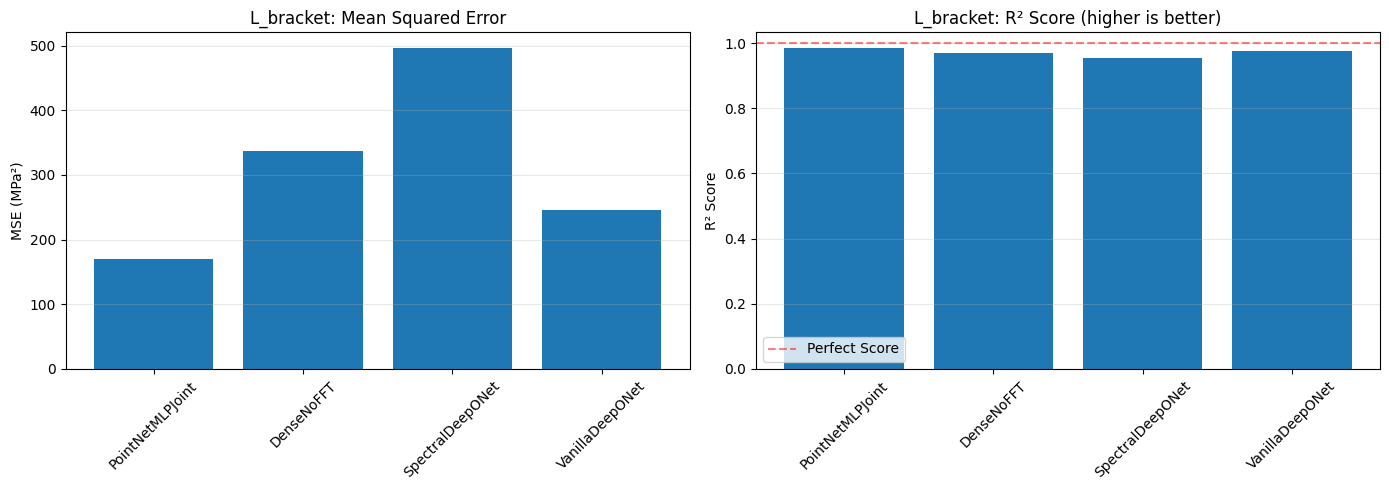

In [17]:
# Visualize L_bracket results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MSE comparison
axes[0].bar(L_bracket_df.index, L_bracket_df['MSE'])
axes[0].set_ylabel('MSE (MPa²)')
axes[0].set_title('L_bracket: Mean Squared Error')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# R² comparison
axes[1].bar(L_bracket_df.index, L_bracket_df['R2'])
axes[1].set_ylabel('R² Score')
axes[1].set_title('L_bracket: R² Score (higher is better)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Perfect Score')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Plate_hole Dataset Comparison

Comparing all models trained on the Plate_hole dataset using the same validation set.

In [18]:
# Load Plate_hole data
print('Loading Plate_hole dataset...')
Plate_hole_samples = load_h5_data(Plate_hole_data_path)
Plate_hole_val_samples, Plate_hole_val_idx = get_validation_split(Plate_hole_samples)
print(f'Total samples: {len(Plate_hole_samples)}')
print(f'Validation samples: {len(Plate_hole_val_samples)}')

Loading Plate_hole dataset...
Total samples: 5000
Validation samples: 1000


In [19]:
# Evaluate all Plate_hole models
print('Evaluating Plate_hole models...\n')
Plate_hole_results = {}

for model_name in ['PointNetMLPJoint', 'DenseNoFFT', 'SpectralDeepONet', 'VanillaDeepONet']:
    print(f'Evaluating {model_name}...')
    model_path = list(model_dirs[model_name].glob('H-*.pt'))[0]
    
    try:
        model, norm_params, ckpt = load_model_and_checkpoint(model_path, model_name)
        metrics = evaluate_model(model, Plate_hole_val_samples, norm_params)
        metrics['Best_Val_Loss'] = ckpt.get('best_val_loss', None)
        Plate_hole_results[model_name] = metrics
        print(f'  MSE: {metrics["MSE"]:.4f}, R²: {metrics["R2"]:.4f}\n')
    except Exception as e:
        print(f'  Error: {e}\n')
        Plate_hole_results[model_name] = {'Error': str(e)}

print('Plate_hole evaluation complete!')

Evaluating Plate_hole models...

Evaluating PointNetMLPJoint...
  MSE: 0.4789, R²: 0.9955

Evaluating DenseNoFFT...
  MSE: 5.6257, R²: 0.9476

Evaluating SpectralDeepONet...
  MSE: 1.5436, R²: 0.9856

Evaluating VanillaDeepONet...
  MSE: 3.4059, R²: 0.9683

Plate_hole evaluation complete!


In [20]:
# Create comparison table for Plate_hole
Plate_hole_df = pd.DataFrame(Plate_hole_results).T
Plate_hole_df = Plate_hole_df.round(4)
print('\n=== Plate_hole Model Comparison ===')
print(Plate_hole_df.to_string())
print(f'\nBest Model (lowest MSE): {Plate_hole_df["MSE"].idxmin()}')
print(f'Best Model (highest R²): {Plate_hole_df["R2"].idxmax()}')


=== Plate_hole Model Comparison ===
                     MSE    RMSE     MAE      R2  Best_Val_Loss
PointNetMLPJoint  0.4789  0.6920  0.4658  0.9955         0.0044
DenseNoFFT        5.6257  2.3719  1.6530  0.9476         0.0520
SpectralDeepONet  1.5436  1.2424  0.8841  0.9856         0.0142
VanillaDeepONet   3.4059  1.8455  1.3247  0.9683         0.0314

Best Model (lowest MSE): PointNetMLPJoint
Best Model (highest R²): PointNetMLPJoint


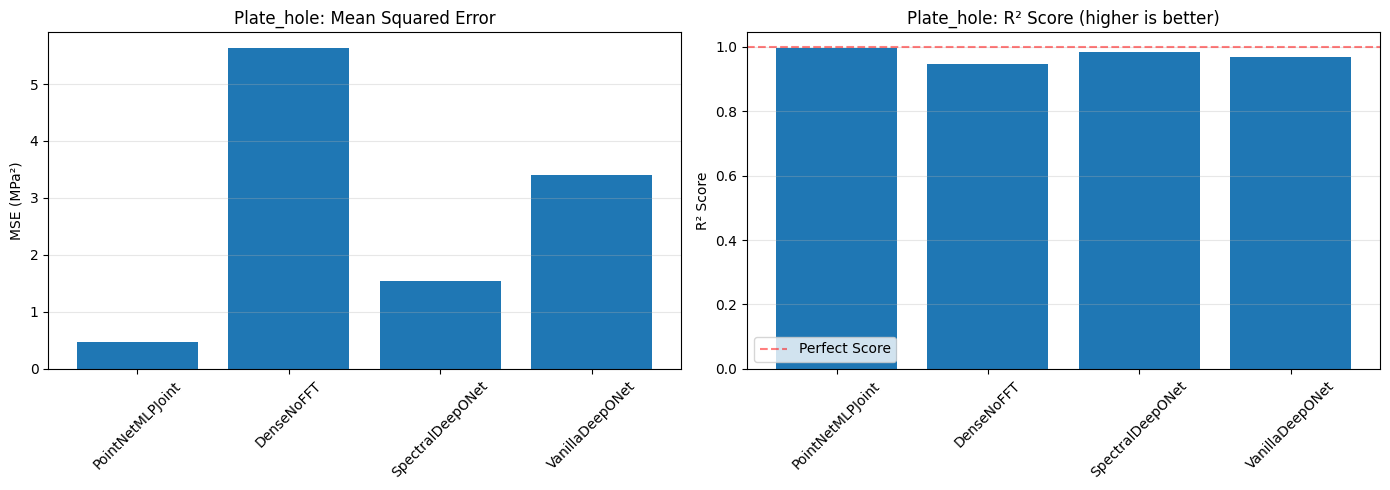

In [21]:
# Visualize Plate_hole results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MSE comparison
axes[0].bar(Plate_hole_df.index, Plate_hole_df['MSE'])
axes[0].set_ylabel('MSE (MPa²)')
axes[0].set_title('Plate_hole: Mean Squared Error')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# R² comparison
axes[1].bar(Plate_hole_df.index, Plate_hole_df['R2'])
axes[1].set_ylabel('R² Score')
axes[1].set_title('Plate_hole: R² Score (higher is better)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Perfect Score')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Test Geometry Visualization

Visualizing how all models perform on test geometries with percentage difference calculations.

In [31]:
def load_example_geometry(path):
    """Load example geometry from HDF5 file."""
    with h5py.File(path, 'r') as hf:
        # Get first sample
        key = list(hf.keys())[0]
        group = hf[key]
        points = group['points'][:]  # (N, 2)
        stress = group['stress'][:]  # (N, 1)
    return torch.from_numpy(points).float(), torch.from_numpy(stress).float()

def predict_on_geometry(model, points, norm_params):
    """Make predictions on a geometry."""
    model.eval()
    with torch.no_grad():
        points = points.to(device)
        
        # Normalize
        points_norm = (points - norm_params['coord_center']) / norm_params['coord_half_range']
        
        # Add batch dimension
        geom_points = points_norm.unsqueeze(0)  # (1, N, 2)
        query_points = points_norm.unsqueeze(0)  # (1, N, 2)
        
        # Predict
        pred_norm = model(geom_points, query_points)  # (1, N, 1)
        
        # Denormalize
        pred = pred_norm * norm_params['stress_std'] + norm_params['stress_mean']
        
    return pred.squeeze().cpu().numpy()

def calculate_percentage_difference(pred, target):
    """Calculate percentage difference for each node."""
    # Avoid division by zero
    mask = np.abs(target) > 1e-6
    pct_diff = np.zeros_like(target)
    pct_diff[mask] = 100 * (pred[mask] - target[mask]) / np.abs(target[mask])
    return pct_diff

print('Test geometry helper functions defined')

Test geometry helper functions defined


## L_bracket Test Geometry

In [32]:
# Load L_bracket test geometry
print('Loading L_bracket test geometry...')
L_test_points, L_test_stress = load_example_geometry(L_bracket_example_path)
print(f'Number of nodes: {L_test_points.shape[0]}')

# Make predictions with all models
L_test_predictions = {}
for model_name in ['PointNetMLPJoint', 'DenseNoFFT', 'SpectralDeepONet', 'VanillaDeepONet']:
    print(f'Predicting with {model_name}...')
    model_path = list(model_dirs[model_name].glob('L-*.pt'))[0]
    model, norm_params, _ = load_model_and_checkpoint(model_path, model_name)
    pred = predict_on_geometry(model, L_test_points, norm_params)
    L_test_predictions[model_name] = pred
    
print('L_bracket test predictions complete!')

Loading L_bracket test geometry...
Number of nodes: 393
Predicting with PointNetMLPJoint...
Predicting with DenseNoFFT...
Predicting with SpectralDeepONet...
Predicting with VanillaDeepONet...
L_bracket test predictions complete!


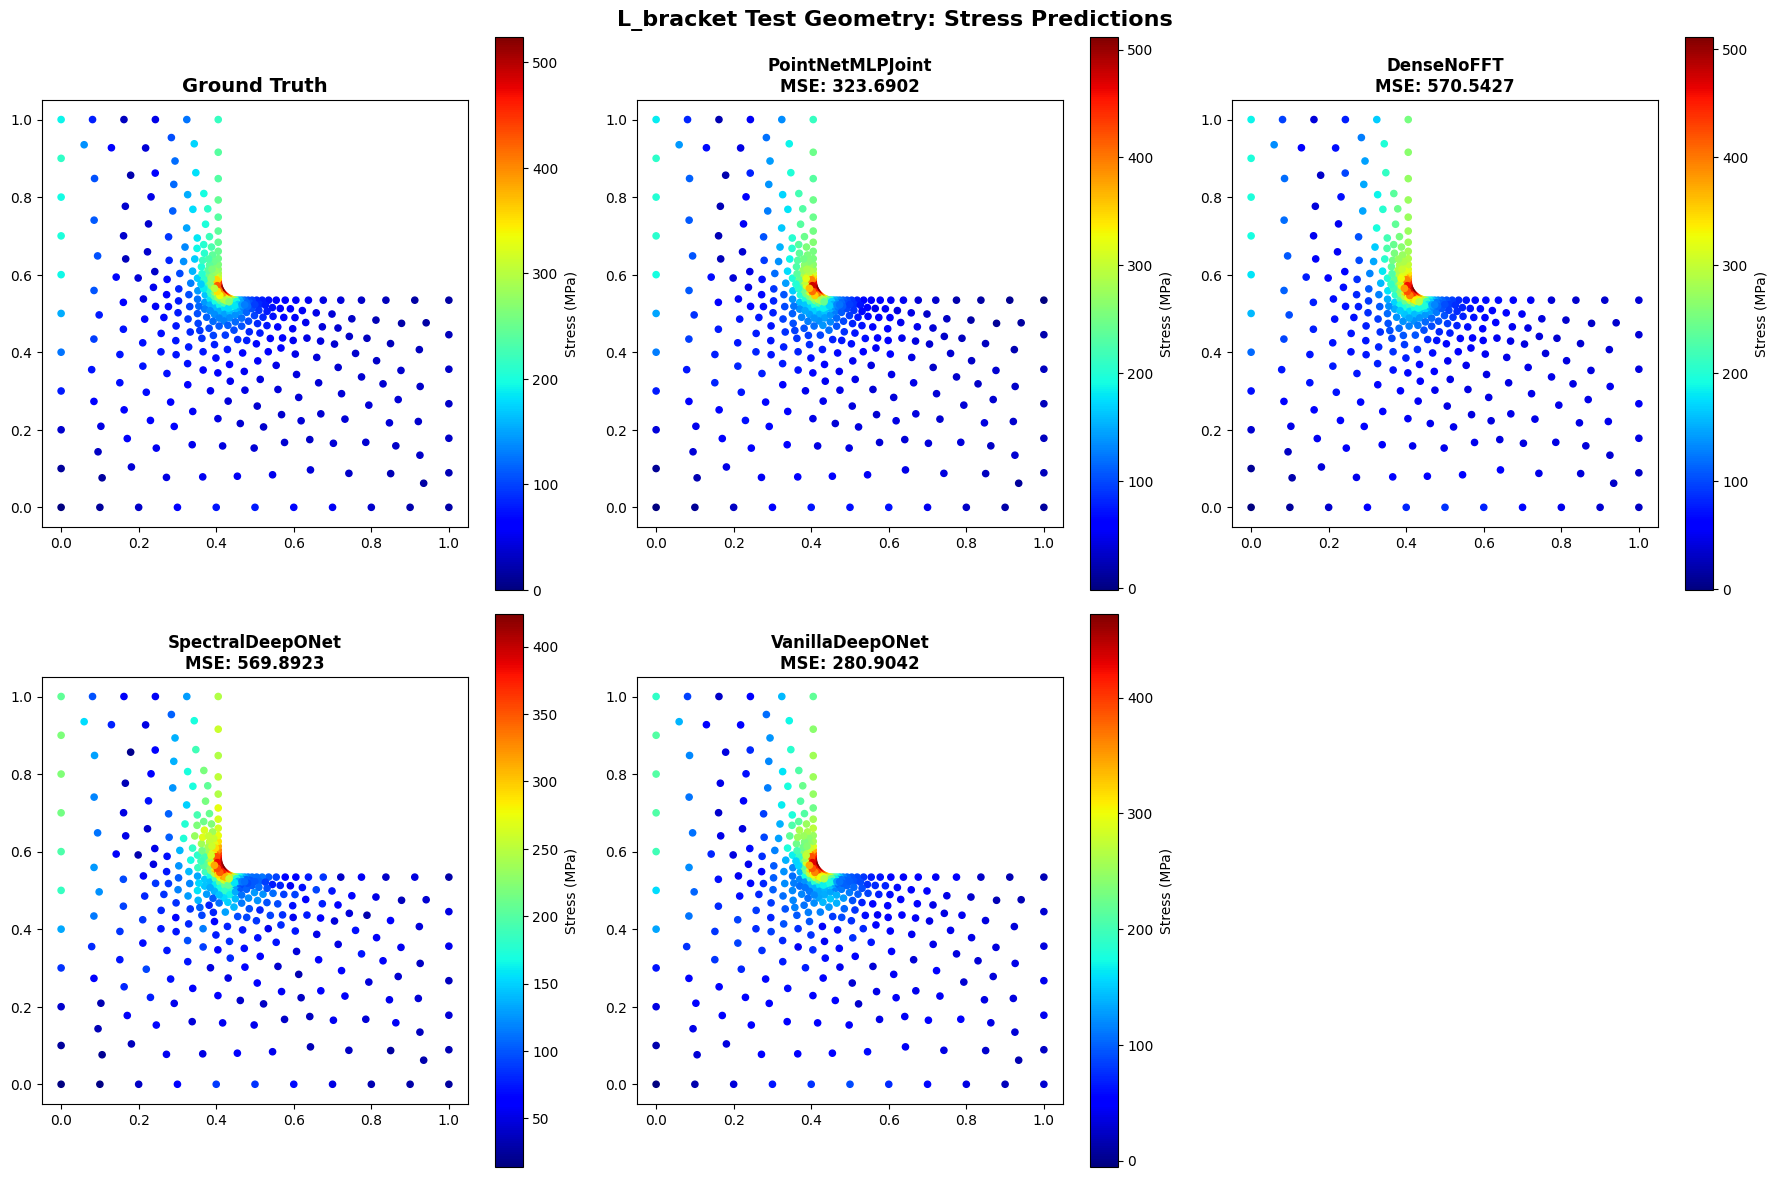

In [33]:
# Visualize L_bracket test results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Ground truth
sc0 = axes[0].scatter(L_test_points[:, 0], L_test_points[:, 1], 
                      c=L_test_stress.squeeze(), cmap='jet', s=20)
axes[0].set_title('Ground Truth', fontsize=14, fontweight='bold')
axes[0].set_aspect('equal')
plt.colorbar(sc0, ax=axes[0], label='Stress (MPa)')

# Model predictions
for idx, (model_name, pred) in enumerate(L_test_predictions.items(), start=1):
    sc = axes[idx].scatter(L_test_points[:, 0], L_test_points[:, 1], 
                          c=pred, cmap='jet', s=20)
    mse = np.mean((pred - L_test_stress.squeeze().numpy())**2)
    axes[idx].set_title(f'{model_name}\nMSE: {mse:.4f}', fontsize=12, fontweight='bold')
    axes[idx].set_aspect('equal')
    plt.colorbar(sc, ax=axes[idx], label='Stress (MPa)')

# Hide extra subplot
axes[5].axis('off')

plt.suptitle('L_bracket Test Geometry: Stress Predictions', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

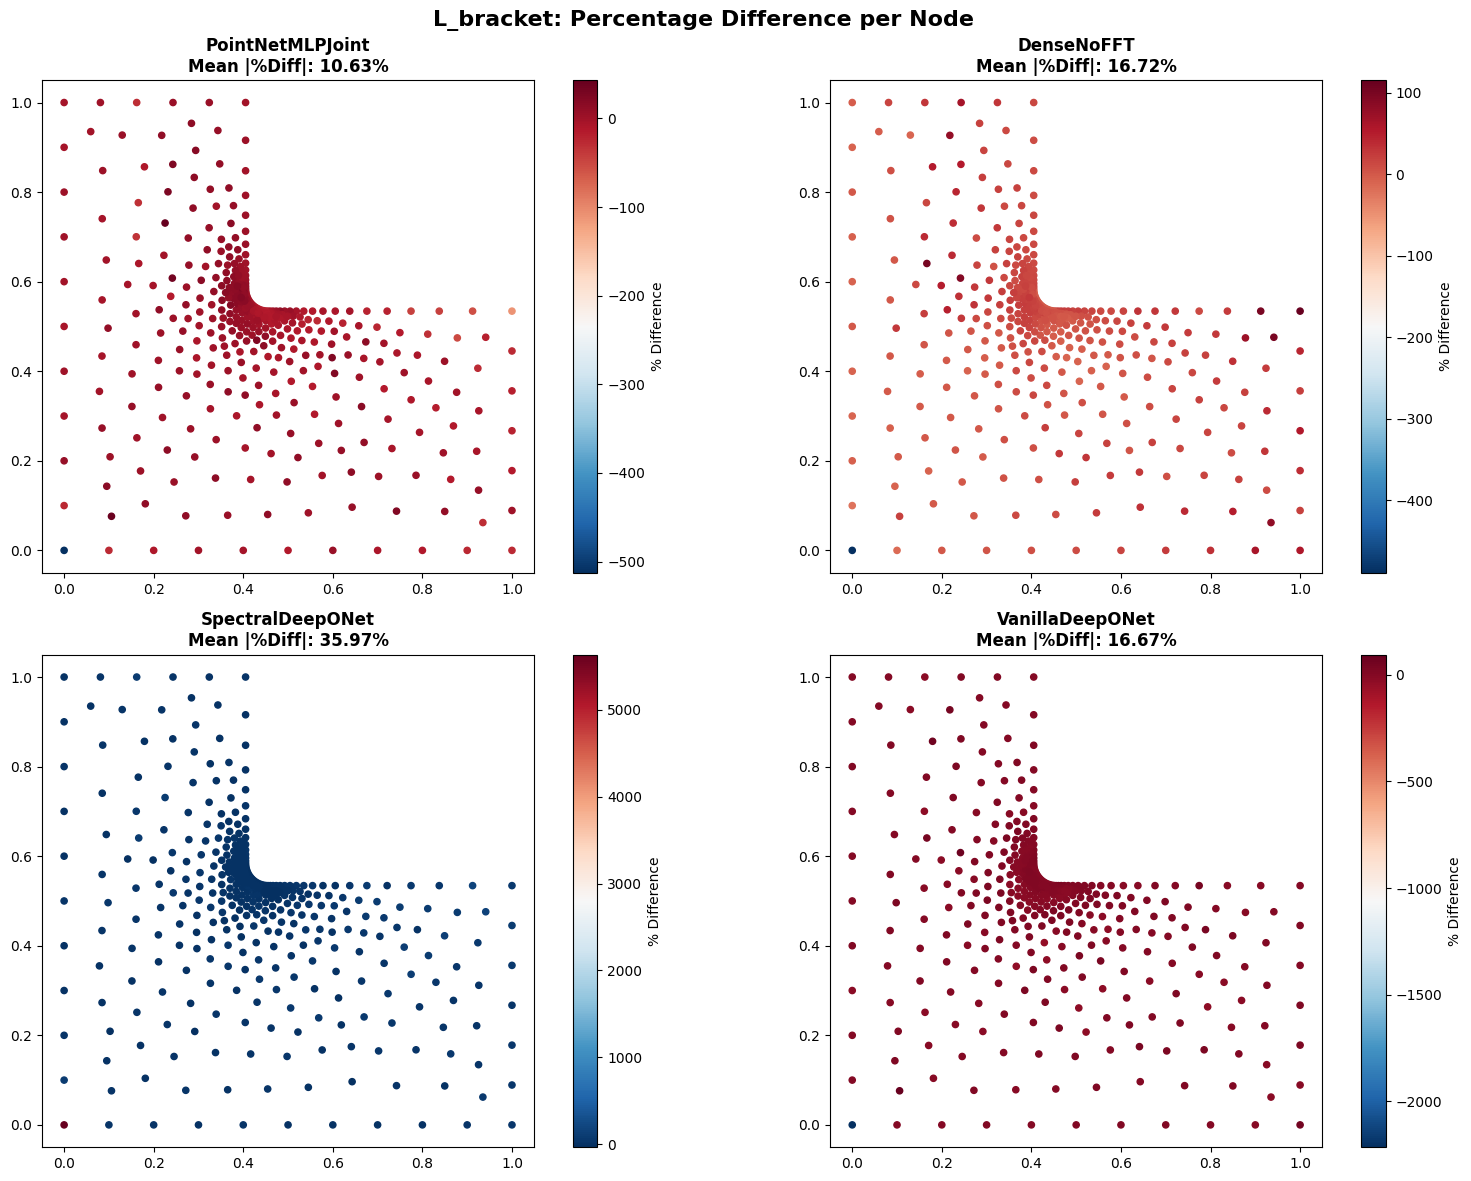


=== L_bracket Percentage Difference Statistics ===

PointNetMLPJoint:
  Mean |%Diff|: 10.63%
  Max |%Diff|: 512.59%
  Std %Diff: 29.10%

DenseNoFFT:
  Mean |%Diff|: 16.72%
  Max |%Diff|: 488.81%
  Std %Diff: 30.44%

SpectralDeepONet:
  Mean |%Diff|: 35.97%
  Max |%Diff|: 5632.19%
  Std %Diff: 284.33%

VanillaDeepONet:
  Mean |%Diff|: 16.67%
  Max |%Diff|: 2215.46%
  Std %Diff: 112.78%


In [34]:
# Calculate and visualize percentage differences for L_bracket
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

target = L_test_stress.squeeze().numpy()

for idx, (model_name, pred) in enumerate(L_test_predictions.items()):
    pct_diff = calculate_percentage_difference(pred, target)
    
    sc = axes[idx].scatter(L_test_points[:, 0], L_test_points[:, 1], 
                          c=pct_diff, cmap='RdBu_r', s=20)
    
    mean_pct = np.mean(np.abs(pct_diff))
    axes[idx].set_title(f'{model_name}\nMean |%Diff|: {mean_pct:.2f}%', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_aspect('equal')
    plt.colorbar(sc, ax=axes[idx], label='% Difference')

plt.suptitle('L_bracket: Percentage Difference per Node', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print statistics
print('\n=== L_bracket Percentage Difference Statistics ===')
for model_name, pred in L_test_predictions.items():
    pct_diff = calculate_percentage_difference(pred, target)
    print(f'\n{model_name}:')
    print(f'  Mean |%Diff|: {np.mean(np.abs(pct_diff)):.2f}%')
    print(f'  Max |%Diff|: {np.max(np.abs(pct_diff)):.2f}%')
    print(f'  Std %Diff: {np.std(pct_diff):.2f}%')

In [35]:
#peak stress relative error for L_bracket test geometry
print('\n=== L_bracket Peak Stress Relative Error ===')
peak_target = np.max(target)
for model_name, pred in L_test_predictions.items():
    peak_pred = np.max(pred)
    relative_error = 100 * np.abs(peak_pred - peak_target) / np.abs(peak_target)
    print(f'{model_name}: Peak Pred = {peak_pred:.4f} MPa, Relative Error = {relative_error:.2f}%')


=== L_bracket Peak Stress Relative Error ===
PointNetMLPJoint: Peak Pred = 512.0133 MPa, Relative Error = 2.30%
DenseNoFFT: Peak Pred = 511.1671 MPa, Relative Error = 2.46%
SpectralDeepONet: Peak Pred = 424.4480 MPa, Relative Error = 19.01%
VanillaDeepONet: Peak Pred = 472.5391 MPa, Relative Error = 9.83%


## Plate_hole Test Geometry

In [36]:
# Load Plate_hole test geometry
print('Loading Plate_hole test geometry...')
P_test_points, P_test_stress = load_example_geometry(Plate_hole_example_path)
print(f'Number of nodes: {P_test_points.shape[0]}')

# Make predictions with all models
P_test_predictions = {}
for model_name in ['PointNetMLPJoint', 'DenseNoFFT', 'SpectralDeepONet', 'VanillaDeepONet']:
    print(f'Predicting with {model_name}...')
    model_path = list(model_dirs[model_name].glob('H-*.pt'))[0]
    model, norm_params, _ = load_model_and_checkpoint(model_path, model_name)
    pred = predict_on_geometry(model, P_test_points, norm_params)
    P_test_predictions[model_name] = pred
    
print('Plate_hole test predictions complete!')

Loading Plate_hole test geometry...
Number of nodes: 447
Predicting with PointNetMLPJoint...
Predicting with DenseNoFFT...
Predicting with SpectralDeepONet...
Predicting with VanillaDeepONet...
Plate_hole test predictions complete!


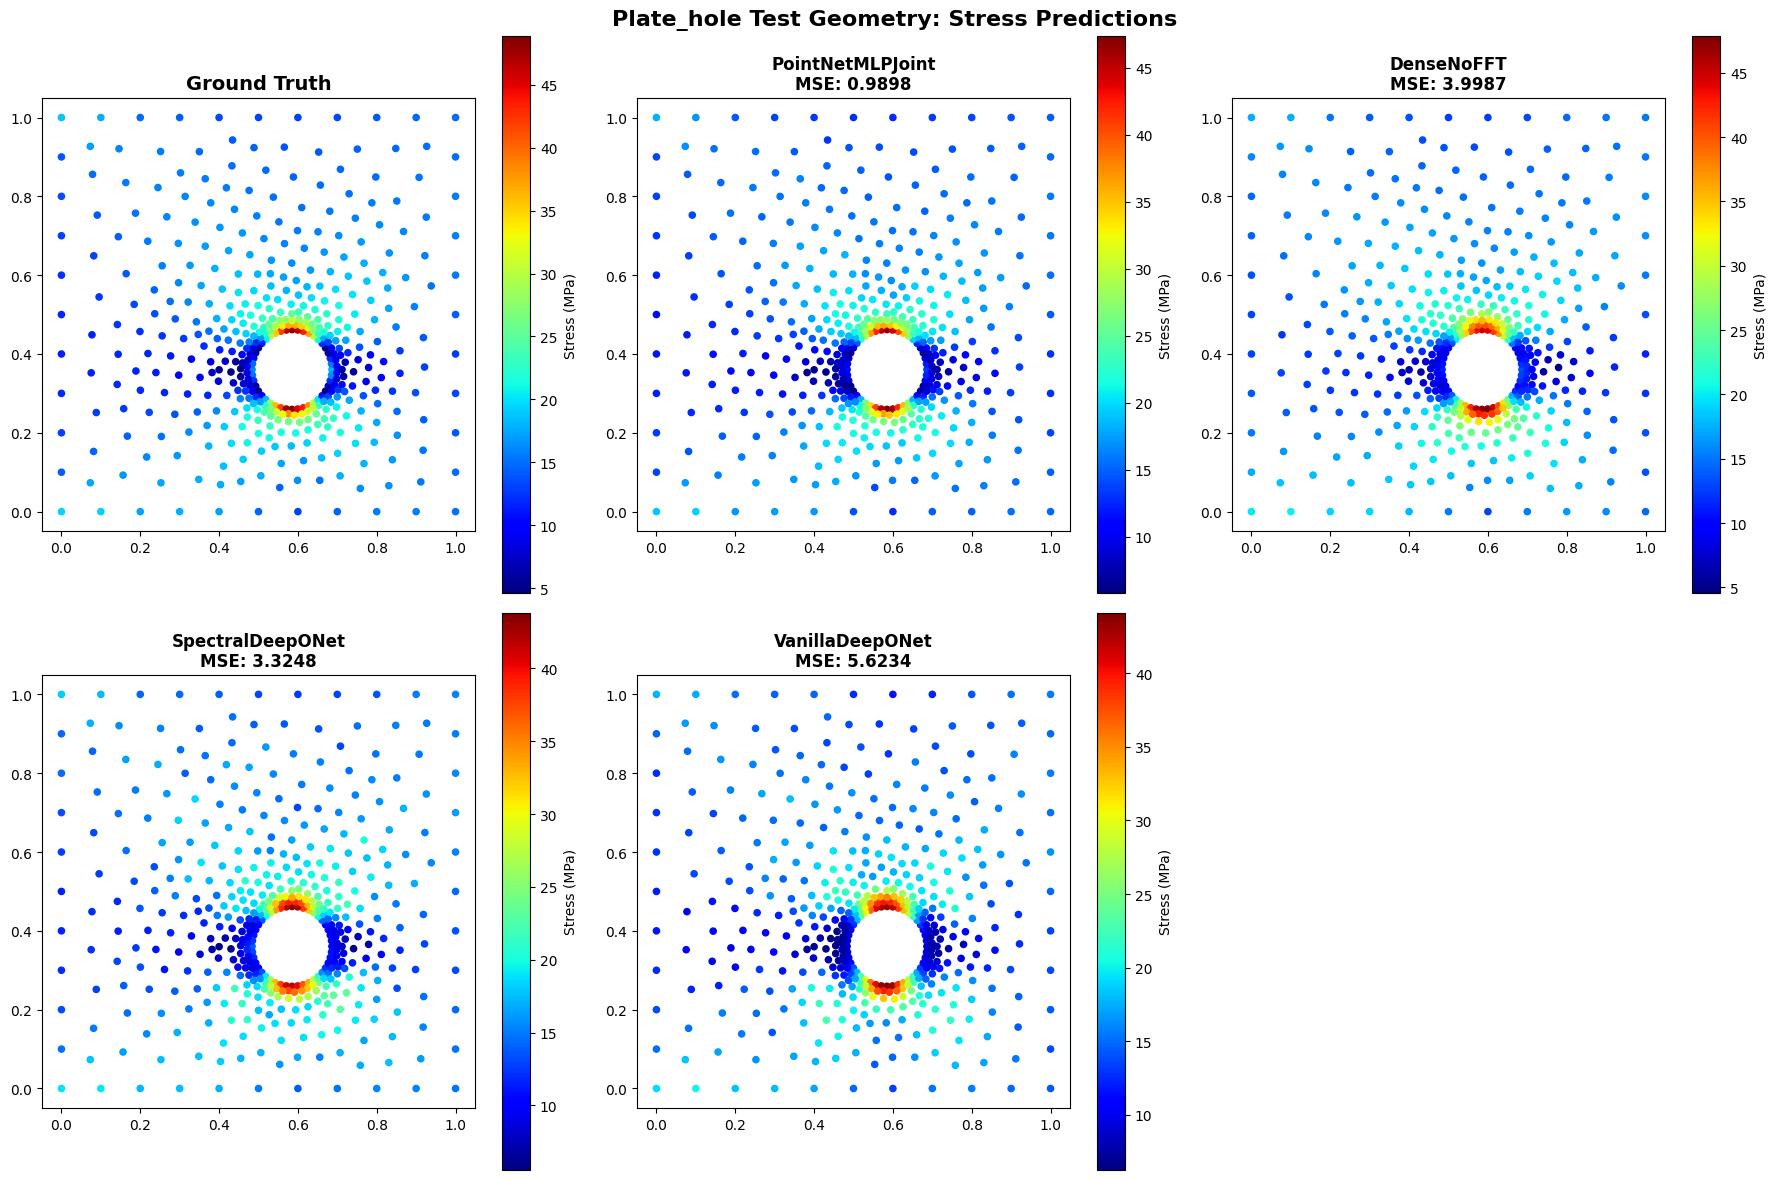

In [37]:
# Visualize Plate_hole test results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Ground truth
sc0 = axes[0].scatter(P_test_points[:, 0], P_test_points[:, 1], 
                      c=P_test_stress.squeeze(), cmap='jet', s=20)
axes[0].set_title('Ground Truth', fontsize=14, fontweight='bold')
axes[0].set_aspect('equal')
plt.colorbar(sc0, ax=axes[0], label='Stress (MPa)')

# Model predictions
for idx, (model_name, pred) in enumerate(P_test_predictions.items(), start=1):
    sc = axes[idx].scatter(P_test_points[:, 0], P_test_points[:, 1], 
                          c=pred, cmap='jet', s=20)
    mse = np.mean((pred - P_test_stress.squeeze().numpy())**2)
    axes[idx].set_title(f'{model_name}\nMSE: {mse:.4f}', fontsize=12, fontweight='bold')
    axes[idx].set_aspect('equal')
    plt.colorbar(sc, ax=axes[idx], label='Stress (MPa)')

# Hide extra subplot
axes[5].axis('off')

plt.suptitle('Plate_hole Test Geometry: Stress Predictions', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

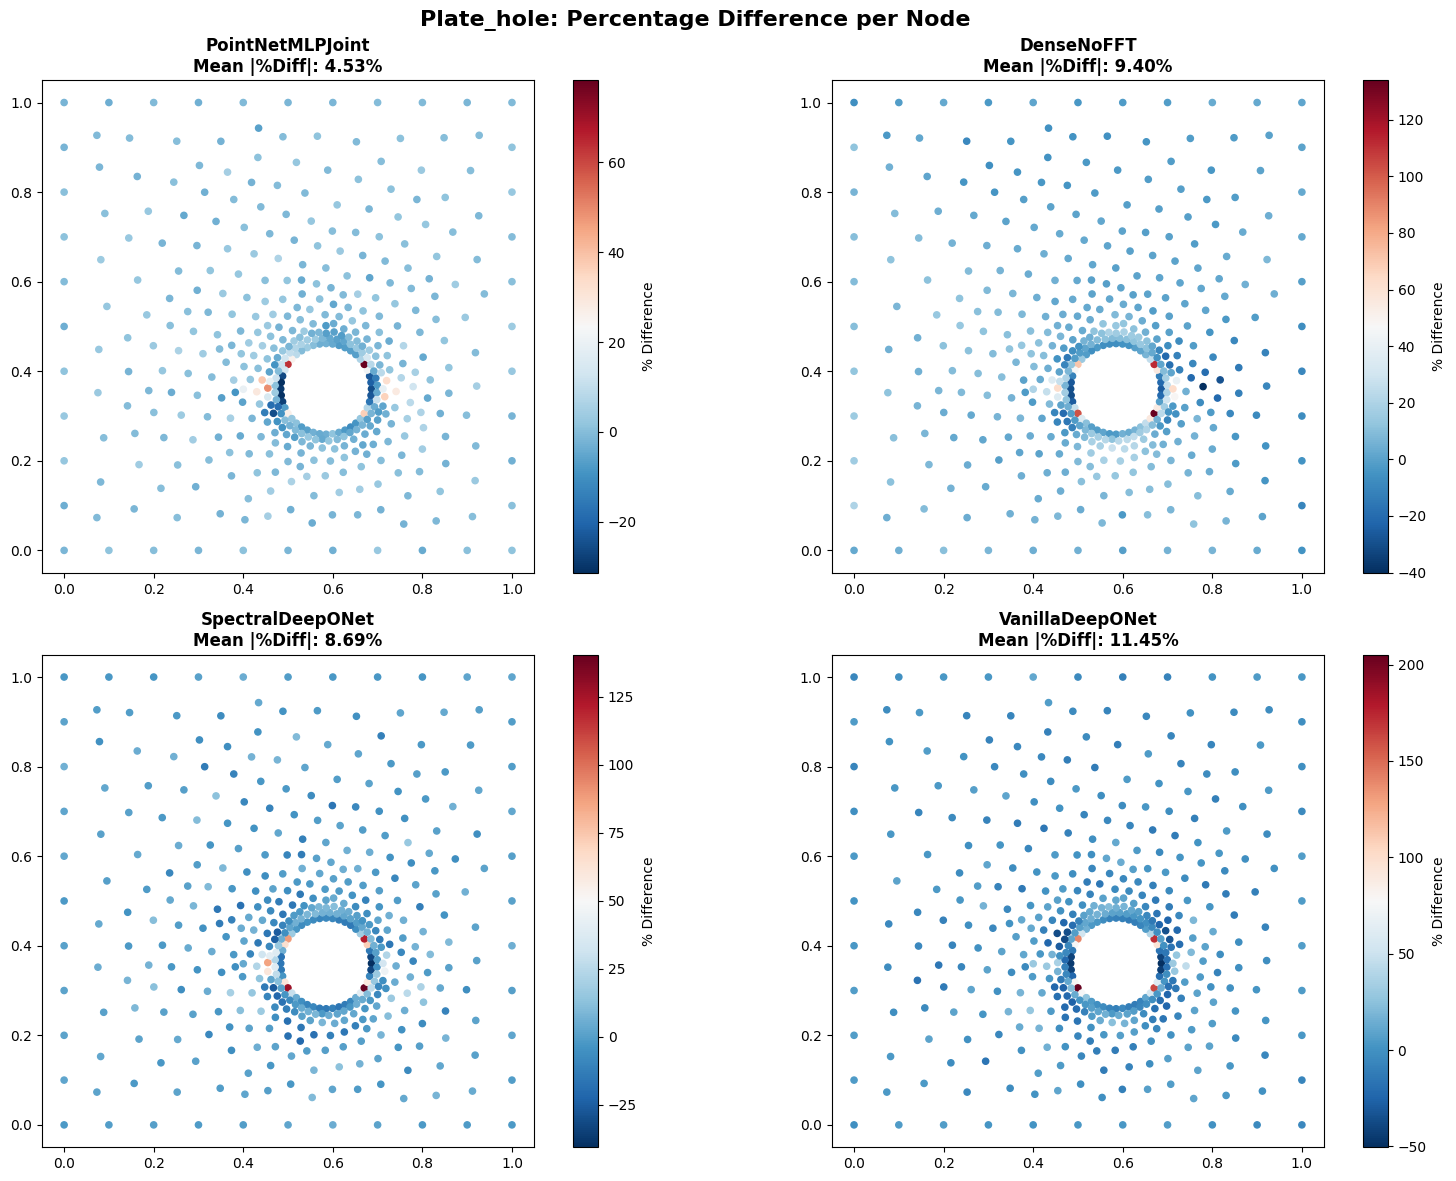


=== Plate_hole Percentage Difference Statistics ===

PointNetMLPJoint:
  Mean |%Diff|: 4.53%
  Max |%Diff|: 78.29%
  Std %Diff: 9.06%

DenseNoFFT:
  Mean |%Diff|: 9.40%
  Max |%Diff|: 134.00%
  Std %Diff: 15.32%

SpectralDeepONet:
  Mean |%Diff|: 8.69%
  Max |%Diff|: 140.55%
  Std %Diff: 16.96%

VanillaDeepONet:
  Mean |%Diff|: 11.45%
  Max |%Diff|: 205.12%
  Std %Diff: 22.22%


In [38]:
# Calculate and visualize percentage differences for Plate_hole
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

target = P_test_stress.squeeze().numpy()

for idx, (model_name, pred) in enumerate(P_test_predictions.items()):
    pct_diff = calculate_percentage_difference(pred, target)
    
    sc = axes[idx].scatter(P_test_points[:, 0], P_test_points[:, 1], 
                          c=pct_diff, cmap='RdBu_r', s=20)
    
    mean_pct = np.mean(np.abs(pct_diff))
    axes[idx].set_title(f'{model_name}\nMean |%Diff|: {mean_pct:.2f}%', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_aspect('equal')
    plt.colorbar(sc, ax=axes[idx], label='% Difference')

plt.suptitle('Plate_hole: Percentage Difference per Node', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print statistics
print('\n=== Plate_hole Percentage Difference Statistics ===')
for model_name, pred in P_test_predictions.items():
    pct_diff = calculate_percentage_difference(pred, target)
    print(f'\n{model_name}:')
    print(f'  Mean |%Diff|: {np.mean(np.abs(pct_diff)):.2f}%')
    print(f'  Max |%Diff|: {np.max(np.abs(pct_diff)):.2f}%')
    print(f'  Std %Diff: {np.std(pct_diff):.2f}%')

In [39]:
#peak stress relative error for plate hole test geometry
print('\n=== Plate_hole Peak Stress Relative Error ===')
peak_target = np.max(target)
for model_name, pred in P_test_predictions.items():
    peak_pred = np.max(pred)
    relative_error = 100 * np.abs(peak_pred - peak_target) / np.abs(peak_target)
    print(f'{model_name}: Peak Pred = {peak_pred:.4f} MPa, Relative Error = {relative_error:.2f}%')
    


=== Plate_hole Peak Stress Relative Error ===
PointNetMLPJoint: Peak Pred = 47.3553 MPa, Relative Error = 3.11%
DenseNoFFT: Peak Pred = 47.8525 MPa, Relative Error = 2.09%
SpectralDeepONet: Peak Pred = 43.8161 MPa, Relative Error = 10.35%
VanillaDeepONet: Peak Pred = 44.0909 MPa, Relative Error = 9.79%


# Summary and Conclusions

This notebook compared all four models on both datasets:
- Validation set performance
- Test geometry predictions
- Per-node percentage differences

Key findings will be displayed above in the comparison tables and visualizations.